In [1]:
import numpy as np
import pandas as pd
from time import strptime
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from math import exp

In [2]:
def bond_ytm(price, fv, T, coup, freq=2, guess=0.05):
#     return Coupon_Bond().get_ytm(price, fv, coup, round(T))
    freq = float(freq)
    periods = T * freq
    coupon = coup * fv / freq
    dt = [(i + 1) / freq for i in range(int(periods))]

    ytm_func = lambda y:  sum([coupon/(1+y/freq)**(freq*t) for t in dt]) + fv/(1+y/freq)**(periods) - price
    return optimize.newton(ytm_func, guess)



In [3]:
def calculate_zero_coupon_rate(price, T, notional = 100):
    return -np.log(price/notional)/T

def get_bond_spot_rate(price, notional, T, coupon_rate, bonds_spot_rate):
    coupon_payment = coupon_rate * notional * 0.5
    if T == 0.5:
        bonds_spot_rate.append(-np.log(price/(notional+coupon_payment))/T)
    else:
        value = price
        coupon_devalue_total = 0
        for t in range(len(bonds_spot_rate)):
            spot_rate_t = bonds_spot_rate[t]
            coupon_devalue_total += coupon_payment * np.exp(-spot_rate_t * data.loc[t, "TimeToMaturity"])
        value -= coupon_devalue_total
        bonds_spot_rate.append( -(np.log(value/(notional+coupon_payment)) / T) )
    return bonds_spot_rate

In [4]:
def bond_spot(price, fv, T, coup, freq=2, guess=0.05):
    freq = float(freq)
    periods = T * freq
    coupon = coup * fv / freq
    
    px_func = lambda Rate: price - (fv * ( 1 + Rate / freq ) ** ( -periods ) + ( coupon / Rate ) * ( 1 - (1 + ( Rate / freq )) ** -periods))
    

    return optimize.newton(px_func, .1, tol=.0001, maxiter=100)

In [5]:
# Import data
data = pd.read_csv("bond_data.csv", encoding="utf-8")

# Pre-process
data['TimeToMaturity'] = (data['MaturityYear'] - 2022) + (data['MaturityMonth'] - 1) / 12


# Define price columns for the 10 days:
pcols = [(11, "pr_11"), (12, "pr_12"), (13, "pr_13"), (14, "pr_14"), (17, "pr_17"), (18, "pr_18"), (19, "pr_19"), (20, "pr_20"), (21, "pr_21"), (24, "pr_24")]

# Increase price according to coupon rate
for index, row in data.iterrows():
    for dayn, pcol in pcols:
        offset = 0
        # Determine days since last coupon payment
        if row["MaturityMonth"] == 5:
            offset = 31
        elif row["MaturityMonth"] == 11:
            offset = 30 + 31
        elif row["MaturityMonth"] == 3:
            offset = 31 + 30 + 31
        elif row["MaturityMonth"] == 9:
            offset = 30 + 31 + 30 + 31
        
        data.loc[index, pcol] = row[pcol] + ((offset + dayn)/365) * row['Coupon']

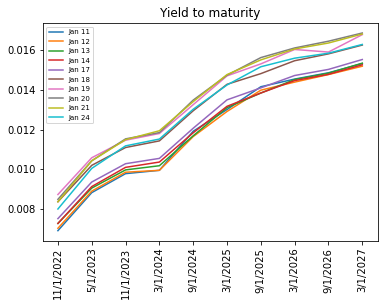

In [6]:
# Plot YTM curve

fig = plt.figure()

mat_yield_full = np.full([10, 10], np.nan) # [day, bond]

for dayc, (dayn, pday) in enumerate(pcols):
    yields = []
    for i_bond, row in data.iterrows():
        yield_rate = bond_ytm(row[pday], 100, row['TimeToMaturity'], row['Coupon'])
        yields.append(yield_rate)
        mat_yield_full[dayc, i_bond] = yield_rate
        data.loc[i_bond, pday + "_ytm"] = yield_rate
    plt.plot(data["MaturityDate"], yields, label=f'Jan {dayn}')

plt.title("Yield to maturity")
plt.legend(fontsize='x-sward_mall')
plt.xticks(rotation=90)
plt.savefig("Yield.png")
plt.show()

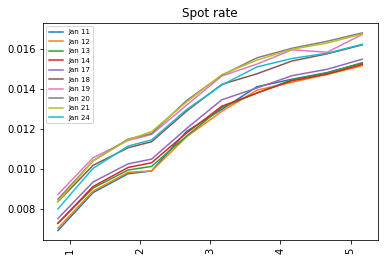

In [7]:
# Plot Spot curve

fig = plt.figure()

for dayn, pday in pcols:
    spots = []
    for i, row in data.iterrows():
        sp = get_bond_spot_rate(row[pday], 100, row['TimeToMaturity'], row['Coupon'], spots)
    data[pday + "_spot"] = sp
    plt.plot(data["TimeToMaturity"], spots, label=f'Jan {dayn}')

plt.title("Spot rate")
plt.legend(fontsize='x-small')
plt.xticks(rotation=90)
plt.savefig("Spot.png")
plt.show()

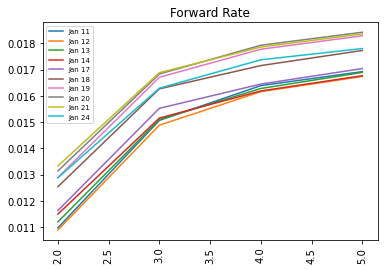

In [8]:
# Plot forward curve

fig = plt.figure()

mat_forward_full = np.full([10, 4], np.nan)

t = [2, 3, 4, 5]
for dayc, (dayn, pday) in enumerate(pcols):
    spot = data[pday + "_spot"]
    forward_curve = []
    for i in range(4):
        fw_rate = (spot[t[i]*2-1] * t[i] - spot[1]) / (t[i] - 1)
        mat_forward_full[dayc, i] = fw_rate
        forward_curve.append(fw_rate)
        
    plt.plot(t, forward_curve, label=f'Jan {dayn}')

plt.title("Forward Rate")
plt.legend(fontsize='x-small')
plt.xticks(rotation=90)
plt.savefig("Forward.png")
plt.show()

In [9]:
# Generate matrices
mat_yield = np.zeros([5, 9])
mat_forward = np.zeros([4, 9])

for i in range(5):
    for j in range(9):
        mat_yield[i, j] = np.log(mat_yield_full[j+1][2*i+1] / mat_yield_full[j][2*i+1])

for i in range(4):
    for j in range(9):
        mat_forward[i, j] = np.log(mat_forward_full[j+1][i] / mat_forward_full[j][i])
        
mat_yield = (mat_yield.T - np.mean(mat_yield.T, axis = 0)).T
mat_forward = (mat_forward.T - np.mean(mat_forward.T, axis = 0)).T

In [10]:
# Calculate covariance
cov_yield = np.cov(mat_yield)
cov_forward = np.cov(mat_forward)

In [11]:
cov_yield

array([[0.00118629, 0.00102281, 0.00084236, 0.00075251, 0.00072526],
       [0.00102281, 0.00094406, 0.00076666, 0.00067956, 0.00065615],
       [0.00084236, 0.00076666, 0.00066383, 0.00059918, 0.00058035],
       [0.00075251, 0.00067956, 0.00059918, 0.00057099, 0.00054755],
       [0.00072526, 0.00065615, 0.00058035, 0.00054755, 0.0005285 ]])

In [12]:
cov_forward

array([[0.00086897, 0.0006412 , 0.00056267, 0.00055226],
       [0.0006412 , 0.00056173, 0.00050954, 0.00050042],
       [0.00056267, 0.00050954, 0.00050432, 0.00048536],
       [0.00055226, 0.00050042, 0.00048536, 0.0004723 ]])

In [13]:
# Calculate eigenvectors
eig_yield = np.linalg.eig(cov_yield)
eig_forward = np.linalg.eig(cov_forward)

In [14]:
eig_yield

(array([3.73881685e-03, 1.08995641e-04, 3.53263838e-05, 9.27094034e-06,
        1.25559009e-06]),
 array([[-0.55144394, -0.58011092, -0.59871869, -0.0267864 ,  0.0141177 ],
        [-0.49431691, -0.30579824,  0.73764732,  0.33940375,  0.0531014 ],
        [-0.4172059 ,  0.21554746,  0.20753789, -0.8309498 , -0.21431047],
        [-0.37915876,  0.52464861, -0.19255667,  0.43244676, -0.59740622],
        [-0.36570238,  0.49823878, -0.13138615,  0.08123919,  0.77081629]]))

In [15]:
eig_forward

(array([2.25533880e-03, 1.33919178e-04, 1.62998839e-05, 1.76213910e-06]),
 array([[-0.59107465, -0.77383681, -0.22557761,  0.03036598],
        [-0.49299692,  0.12456425,  0.83758888, -0.19970642],
        [-0.45697307,  0.46542371, -0.47837713, -0.58797253],
        [-0.44582554,  0.41114609, -0.13680254,  0.78325191]]))